In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3*x**2 - 4*x +5

In [4]:
f(3.0)

20.0

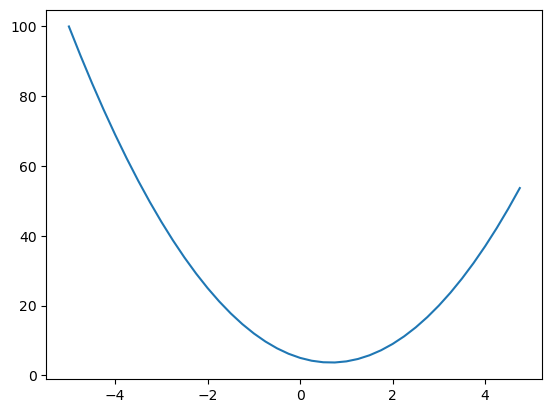

In [5]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [6]:
h=0.00001
x=3.0
(f(x+h) - f(x))/h
#if we slighlt nudge x in the +ve dir, how will the fn respond

14.00003000000538

In [7]:
h=0.00001
x=-3.0
(f(x+h) - f(x))/h

-21.999970000052823

In [8]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
d

4.0

In [9]:
h=0.0001
a=2.0
b=-3.0
c=10.0

d1=a*b+c
c+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)
#by how much the fn inc, when an input was bumped by a tiny value and further normalized


d1 4.0
d2 4.0001
slope 0.9999999999976694


neural networks are massive expressions and will need some data structures to maintain them..

In [48]:
class Value:

    def __init__(self,data, _children=(), _op='',label=''):
        self.data=data
        self.grad=0.0 #at initialization, by default, value does not affect the output
        self._backward=lambda:None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            #out=self + other
            self.grad+= 1.0 * out.grad #dL/dself= dout/dself* dL/dout=1 * dL/dout
            other.grad+= 1.0 * out.grad #dL/dother=dout/dother * dL/dout=1 * dL/dout
        out._backward=_backward
        return out
    
    def __radd__(self,other):
        return self + other
    def __mul__(self,other):
       other=other if isinstance(other, Value) else Value(other)
       out=Value(self.data*other.data,(self,other),'*')
       def _backward():
           #out=self * other
           self.grad+=other.data * out.grad #dL/dself=dout/dself * dL/dout=other * dL/dout
           other.grad+= self.data * out.grad
       out._backward=_backward
       return out
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out=Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            #out=x**k
            #dL/dself= dout/dself * dL/dout = (k)x**(k-1) * out.grad
            self.grad+= ((other)*self.data**(other-1)) * out.grad
        out._backward=_backward
        return out

    def __rmul__(self,other): #other *self
        return self * other
    
    def __truediv__(self,other): #self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self,other): # self-other
        return self + (-other)
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self, ), 'tanh')

        def _backward():
            self.grad+=(1-t**2) * out.grad 
        out._backward=_backward
        return out

    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self, ),'exp')

        def _backward():
            #out=exp(self)
            self.grad+=math.exp(x)*out.grad # dL/dself=dout/dself*dL/dout=
        out._backward=_backward

        return out

    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()
            

# a=Value(2.0,label='a')
# b=Value(-3.0,label='b')
# c=Value(10.0,label='c')
# e=a*b; e.label='e'
# a+b #initially,error, since python doesnt know how to add 2 value objects
# a*b # __mul__
# d=e+c; d.label='d'
# (a.__mul__(b)).__add__(c)
# f=Value(-2.0,label='f')
# L=d*f; L.label='L'
# L

In [11]:
# d._prev
# (a*b) is Value(data=-6.0) and c is Value(data=10.0)

In [12]:
#d._op # d was produced by addition of 2 values (a*b) and (c)

In [13]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot=Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes,edges=trace(root)

    for n in nodes:
        uid=str(id(n))
        #for any value in the graph, create a recangular ('record') node fo rit
        dot.node(name=uid,label="{%s|data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape='record') 
        if n._op:

            dot.node(name=uid+n._op,label=n._op)

            dot.edge(uid+n._op,uid)
    
    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot





In [14]:
# <!-- L = d* f
# # dL/dd = ? f -->
# f.grad=4.0
# d.grad=-2


In [15]:
# L.grad=1

In [16]:
# c.grad=-2.0
# e.grad=-2.0

In [17]:
# a.grad=-2.0 * -3.0
# b.grad=-2.0 * 2.0

In [18]:
#dl/da=(dL/de)*(de/da)
draw_dot(L)

NameError: name 'L' is not defined

In [19]:

# def  lol():

#     h=0.0001

#     a=Value(2.0,label='a')
#     b=Value(-3.0,label='b')
#     c=Value(10.0,label='c')
#     e=a*b; e.label='e'
#     d=e+c;d.label='d'
    
#     f=Value(-2.0,label='f')
#     L=d*f;L.label='L'
#     L1=L.data

#     a=Value(2.0+h,label='a')
#     b=Value(-3.0,label='b')
#     c=Value(10.0,label='c')
#     e=a*b; e.label='e'
#     d=e+c;d.label='d'
    
#     f=Value(-2.0,label='f')
#     L=d*f;L.label='L'
#     L2=L.data

#     print((L2-L1)/h) #derivative of L wrt a
    
# lol()
    


In [20]:
a.data +=0.01 * a.grad
b.data+=0.01 * b.grad
c.data+=0.01 * c.grad
f.data+=0.01 * f.grad

e=a*b
d=e+c
L=d*f

print(L.data)

AttributeError: 'float' object has no attribute 'data'

In [21]:
#plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); plt.grid();

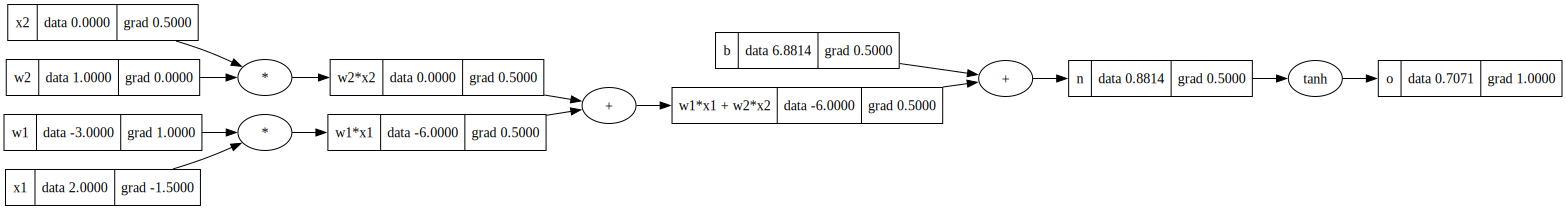

In [22]:
#inputs x1,x2
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

#weights w1, w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias
b=Value(6.8813735870195432,label='b')

#w1x2+w2x2+b
w1x1=w1*x1; w1x1.label='w1*x1';
w2x2=w2*x2; w2x2.label='w2*x2';

w1x1_w2x2=w1x1+w2x2; w1x1_w2x2.label='w1*x1 + w2*x2'
n=w1x1_w2x2 + b ; n.label='n'
#-----
o=n.tanh(); 
o.label='o'
o.backward()

draw_dot(o)

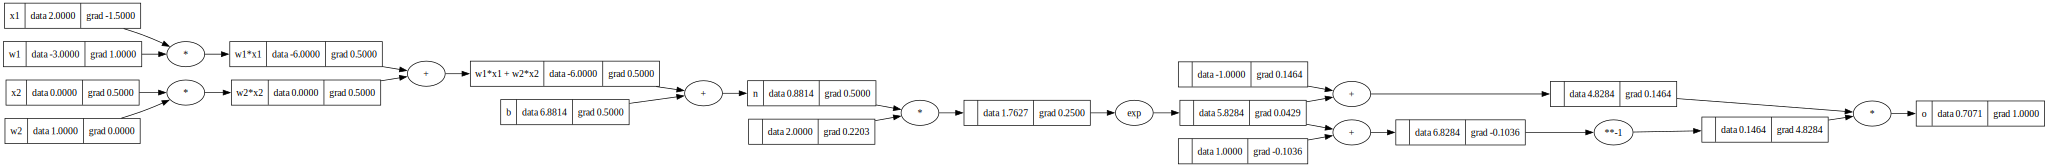

In [23]:
#inputs x1,x2
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

#weights w1, w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias
b=Value(6.8813735870195432,label='b')

#w1x2+w2x2+b
w1x1=w1*x1; w1x1.label='w1*x1';
w2x2=w2*x2; w2x2.label='w2*x2';

w1x1_w2x2=w1x1+w2x2; w1x1_w2x2.label='w1*x1 + w2*x2'
n=w1x1_w2x2 + b ; n.label='n'
#-----
# o=n.tanh(); 
e=(2*n).exp()
o=(e-1)/(e+1)
o.label='o'
o.backward()

draw_dot(o)

In [24]:
# o.backward()

In [25]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo


In [26]:
# o.grad=1.0

In [27]:
# o._backward()
# n._backward()
# #b._backward() #error
# w1x1_w2x2._backward()
# w2x2._backward()
# w1x1._backward()

In [28]:
# x1.grad=w1.data * w1x1.grad
# w1.grad=x1.data * w1x1.grad
# x2.grad=w2.data* w2x2.grad 
# w2.grad=x2.data * w2x2.grad
# w1x1.grad=0.5
# w2x2
# w1x1_w2x2.grad=0.5

In [29]:

# b.grad=0.5
# #o=tanh(n)
# #n.grad=do/dn?= 1-tanh^2(n) = 1-o**2

# n.grad=1-o.data**2

# o.grad=1.0

In [30]:
### fixing a bug

# a=Value(3.0,label='a')
# b=a+a; b.label='b'
# b.backward()
# draw_dot(b)


In [31]:
#a=Value(2.0) 
#a + 1 # error # because 1.data is not a thing!
# to counter this: isinstance()

# a=Value(2.0)
# a*2

#now,
    #2*a wont work, since it's 2.__mul(a)
    #counter-> def __rmul__(self,other)
        #if python cannot perform 2 * a, it will implictly check a*2 due to __rmul__


In [32]:
a=Value(2.0)
b=Value(4.0)
#a/b # doesnt work
#a * (1/b) # doesnt work
#a * (b**-1) # doesnt work

    #counter: implement __truediv__ for self/other

    #counter: implement x**k pow fn
#a/(b) # works

#a-b # error
    #counter: __neg__ and __sub__


### Using pytorch

In [33]:
import torch

x1=torch.Tensor([2.0]).double()           ;   x1.requires_grad=True
x2=torch.Tensor([0.0]).double()           ;   x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()           ;   w1.requires_grad=True
w2=torch.Tensor([1.0]).double()           ;   w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double()           ;   b.requires_grad=True

n=x1*w1 + x2*w2 + b
o=torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())



0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [71]:
import random
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x): #n(x) implicitly triggers call
        #w*x+b
       act=sum((wi*xi for wi, xi  in zip(self.w,x)), self.b) 
       out=act.tanh()
       return out

    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        


class MLP:
    def __init__(self,nin,nouts):
        sz=[nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x=[2.0,3.0,-1.0]
# n=Neuron(2)
# n(x)

# n=Layer(2,3) 
n=MLP(3,[4,4,1])
n(x)
     

Value(data=0.3981526013660905)

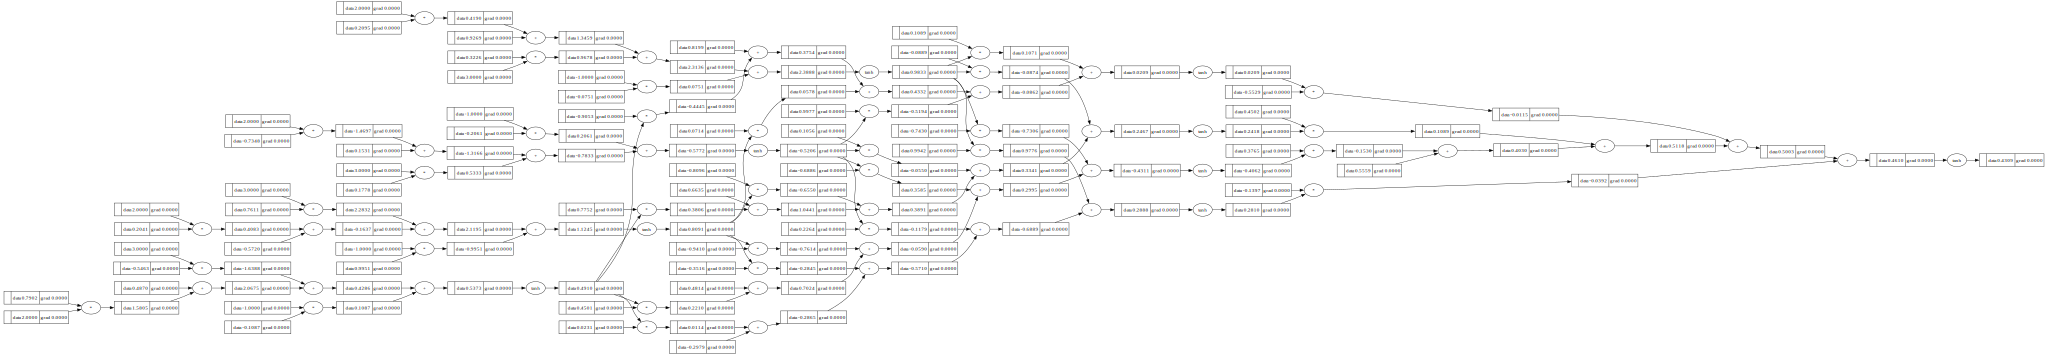

In [52]:
draw_dot(n(x))

In [53]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ypred=[n(x) for x in xs]
ypred

[Value(data=0.43092400854377433),
 Value(data=0.926819498354149),
 Value(data=0.048733687023287606),
 Value(data=0.7930445150151919)]

In [54]:
loss= [(yout-ygt)**2 for ygt, yout in zip(ys,ypred)]
loss

[Value(data=0.32384748405188624),
 Value(data=3.712633379237735),
 Value(data=1.0998423462974587),
 Value(data=0.04283057276529713)]

In [57]:
loss=sum(loss)

In [58]:
loss.backward()

In [60]:
n.layers[0].neurons[0].w[0].grad 
#it's negative
#slightly inc the weight of the neuron from this layer would 
#make loss go down

-0.5827111495211649

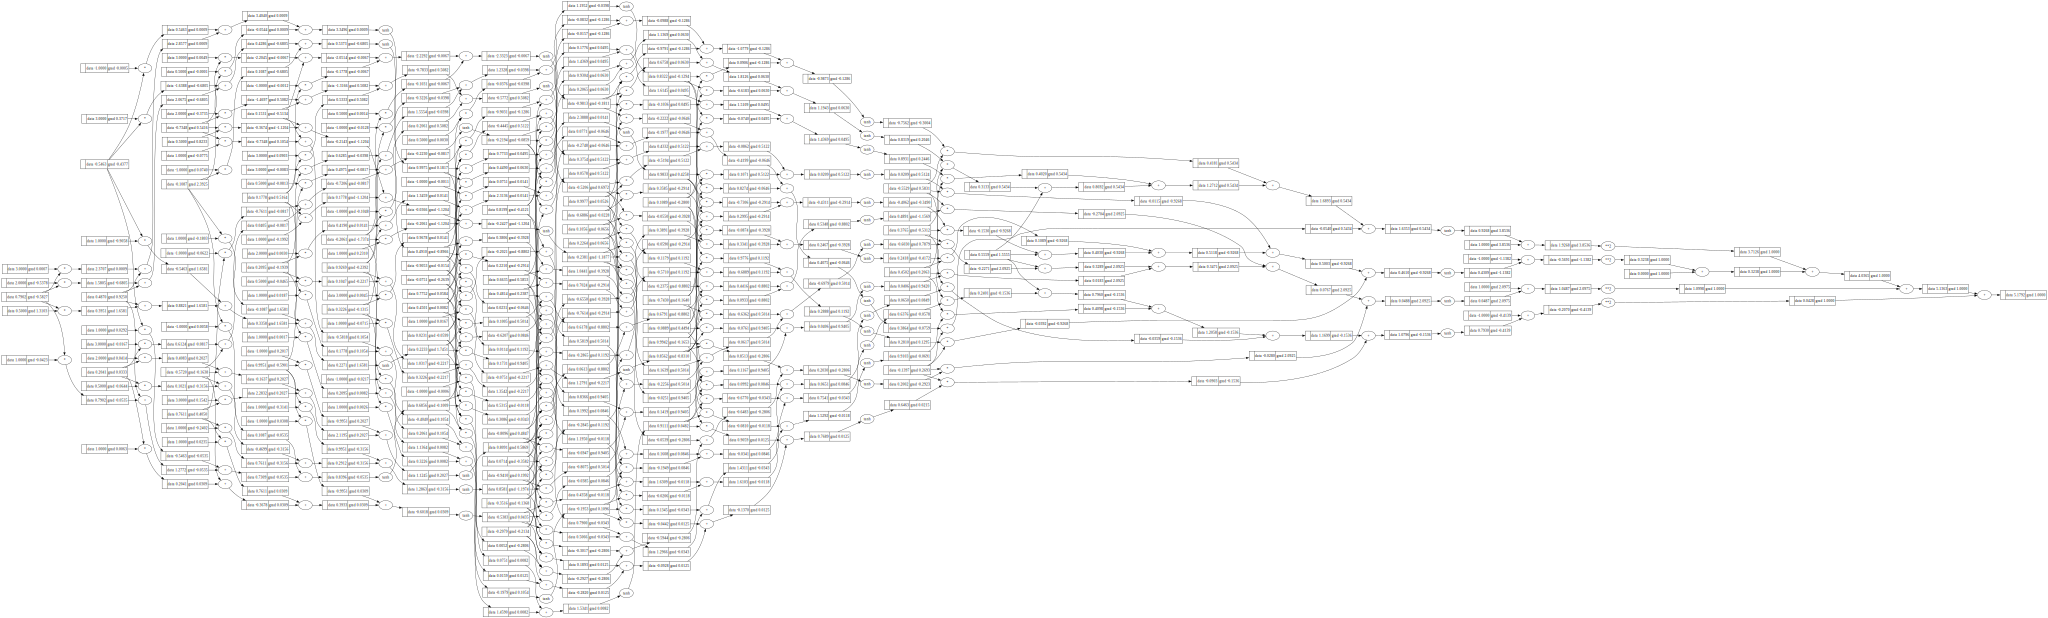

In [65]:
draw_dot(loss)


In [79]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.985461847919143)

In [80]:
n.layers[0].neurons[0].w[0].grad

0.0

In [81]:
n.parameters()

[Value(data=0.28442385148217264),
 Value(data=-0.999564615667847),
 Value(data=-0.7106732524121149),
 Value(data=-0.6702529042560268),
 Value(data=0.7602919630450613),
 Value(data=-0.444186369678385),
 Value(data=0.16266599842535534),
 Value(data=0.758181466908513),
 Value(data=-0.4649965884675116),
 Value(data=0.4803955060105183),
 Value(data=-0.08296843303903412),
 Value(data=0.30423763424459294),
 Value(data=-0.7055383036550102),
 Value(data=-0.8476797799764184),
 Value(data=-0.6245693481608219),
 Value(data=0.23045414063784464),
 Value(data=0.5055103539095054),
 Value(data=0.1586936908484693),
 Value(data=-0.999396619825484),
 Value(data=0.11317777024159215),
 Value(data=-0.6425471595621326),
 Value(data=-0.44986484080623934),
 Value(data=-0.9118844186086121),
 Value(data=-0.7444302806630994),
 Value(data=-0.5729747642663634),
 Value(data=0.9891394571844856),
 Value(data=-0.6479417157800225),
 Value(data=-0.22479677472131288),
 Value(data=-0.3246972698457138),
 Value(data=0.7026267

In [82]:
len(n.parameters())

41

In [83]:
for p in n.parameters():
    p.data+=0.01*p.grad

In [84]:
n.layers[0].neurons[0].w[0].grad

0.0

In [85]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 6.716885561370341
1 4.240361467979091
2 3.863382377824018
3 3.7226697663710517
4 3.4865482875759395
5 2.999785857432722
6 2.411094142306779
7 1.759161966282131
8 1.2803053392466506
9 2.496258867515066
10 0.12120755058676919
11 0.059381006397154275
12 0.047835872826842846
13 0.04129227181561721
14 0.036713248703629645
15 0.03318490480535362
16 0.03032450791721245
17 0.027934555882218277
18 0.02589736840704176
19 0.024135570835746117


In [86]:
ypred

[Value(data=0.896482543728094),
 Value(data=-0.9718672696718695),
 Value(data=-0.8996019300457803),
 Value(data=0.9495174870228072)]